# [IAPR 2018:][iapr2018] Lab 1 -  Image segmentation

**Author:** Christine Roth
**Due date:** 20.04.2018

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

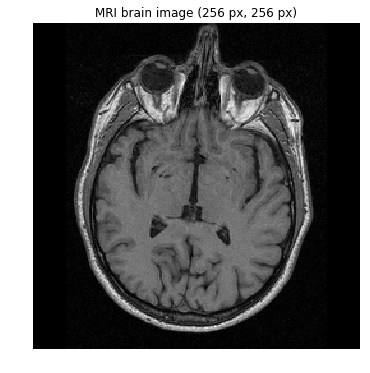

In [2]:
###############################
#BRAIN ANALYSIS
###############################
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff')) #skimage cree des np...
#type(brain_im)
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
First of all we plot a histogramm to identify by eye where a good treshold might be.

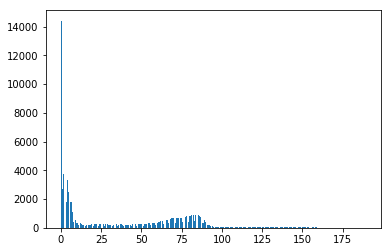

In [3]:
#Histogramm to determine good treshold
import numpy as np
import matplotlib.pyplot as plt

plt.hist(brain_im.ravel(),bins=256);

Now we use a region growing method implemented  by Quentin Desaulty using a [Pseudo Code called Flood Fill](https://en.wikipedia.org/wiki/Flood_fill)

It allows to define seeds, initial coordinates for the region growing and a minimal and maximal treshold between which the region is allowed to grow.

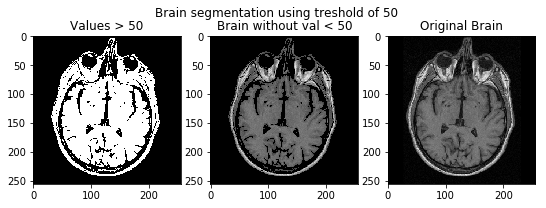

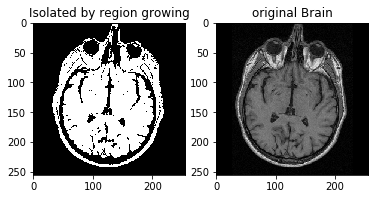

Brain size =  24339  using treashold of  50
_______________________________________________________________________________


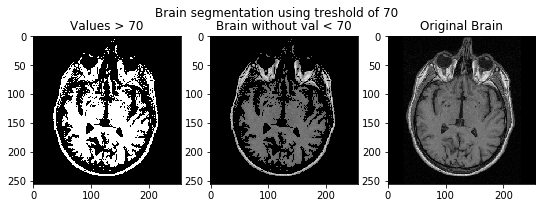

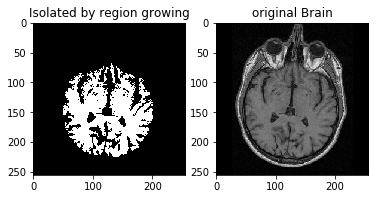

Brain size =  12367  using treashold of  70


In [4]:
# Implementation of flood fill : https://en.wikipedia.org/wiki/Flood_fill
# * prermets de passer plusieurs elements
def regionGrowing(z, bm, bs, *seed):
	neighbours = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]
	mask = np.zeros_like(z)
	stack=[]
	stack.extend(seed) # push start coordinate on stack

	while stack:
    		x, y = stack.pop()
    		mask[x, y] = True
    		for dx, dy in neighbours:
        		nx, ny = x + dx, y + dy
        		if (0 <= nx < z.shape[0]) and (0 <= ny < z.shape[1]) and (not mask[nx, ny]) and (z[nx, ny] <= bs) and (z[nx, ny] >= bm):
            			stack.append((nx, ny))
	return mask
#example region growing with minimal treshold 50
tres=50;
bin_tres=brain_im>tres;
brain_tres=brain_im.copy();
brain_tres[brain_im<=tres]=1;
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
fig.suptitle("Brain segmentation using treshold of %d"%tres)
ax[0].imshow(bin_tres, cmap='gray')
ax[0].set_title("Values > %d"%tres)
ax[1].imshow(brain_tres, cmap='gray')
ax[1].set_title("Brain without val < %d"%tres)
ax[2].imshow(brain_im,cmap='gray')
ax[2].set_title("Original Brain")
plt.show()
SEED=(150,80);
mask=regionGrowing(brain_im,tres,255,(220 ,105),SEED)
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Isolated by region growing")
ax[1].imshow(brain_im,cmap='gray')
ax[1].set_title("original Brain")
plt.show()
size=np.sum(mask)
sssize=mask.sum()
print("Brain size = ",sssize," using treashold of ",tres)
print("_______________________________________________________________________________")
#example region growing with minimal treshold 70
tres=70;
bin_tres=brain_im>tres;
brain_tres=brain_im.copy();
brain_tres[brain_im<=tres]=1;
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
fig.suptitle("Brain segmentation using treshold of %d"%tres)
ax[0].imshow(bin_tres, cmap='gray')
ax[0].set_title("Values > %d"%tres)
ax[1].imshow(brain_tres, cmap='gray')
ax[1].set_title("Brain without val < %d"%tres)
ax[2].imshow(brain_im,cmap='gray')
ax[2].set_title("Original Brain")
plt.show()
SEED=(150,80);
mask=regionGrowing(brain_im,tres,255,(220 ,105),SEED)
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Isolated by region growing")
ax[1].imshow(brain_im,cmap='gray')
ax[1].set_title("original Brain")
plt.show()
size_m=np.sum(mask)
print("Brain size = ",size_m," using treashold of ",tres)


Using a treashold allows to seperate the region of the brain from the os. However important parts of the brain matter are  not identified. The optimal treshold for this method was tested to be 70 as it is the minimum value for which the bone is seperated from the brain matter. However as can be seen on the figures above, the darker parts of the brain matter are completely lost.

### 1.3 Contour detection
The canny method form the is an edge detection tool. It uses a multi-stage algorithm to detect a wide range of edges. It can be broken down to 5 steps:

    1. Apply Gaussian filter to smooth the image and remove noise
    2. Find intensity gradients of the image
    3. Apply non-maximum suppression to get rid of supurious response to edge detection
    4. Apply double treshold to determine potential edges
    5. Track edges by suppressing all weak edges
[Source: WIKIPEDIA-Canny Edge Detector](https://en.wikipedia.org/wiki/Canny_edge_detector)

The canny method is implemented in [skimage.feature.canny](http://scikit-image.org/docs/0.5/auto_examples/plot_canny.html)

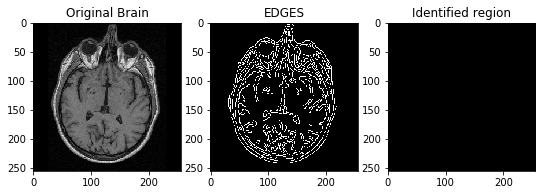

In [5]:
#CONTOUR DETECTION
from skimage import feature
edge=feature.canny(brain_im)
brain=regionGrowing(edge,1,1.5,(220 ,105),SEED )
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title("Original Brain")
ax[1].imshow(edge, cmap='gray')
ax[1].set_title("EDGES")
ax[2].imshow(brain,cmap='gray')
ax[2].set_title("Identified region")
plt.show()

Applying the canny method without a gaussian filter results in a to detailed edge detection. As the image is not smoothed, thus no continuous contour is obtained. In combination with the region growing method needed to identify the size of the brain matter, the result is useless as no brain is detected in the end.

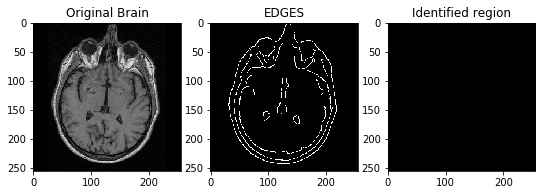

In [6]:
edge=feature.canny(brain_im,sigma=3)
brain=regionGrowing(edge,1,1.5,(220 ,105),SEED )
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title("Original Brain")
ax[1].imshow(edge, cmap='gray')
ax[1].set_title("EDGES")
ax[2].imshow(brain,cmap='gray')
ax[2].set_title("Identified region")
plt.show()

It is clearly visible, that this method allows to simplify the brain structure. However if it stands alone, it is difficult to extract a clear image. To improve this method, closing and opening can be applied. To close the contour.

Here we use the [binary_closing](http://scikit-image.org/docs/dev/api/skimage.morphology.html) provided in skimage.

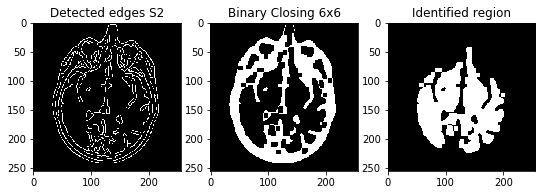

In [7]:
#binary closing
from skimage import morphology
edge=feature.canny(brain_im,sigma=1.6)
edge2=morphology.binary_closing(edge,np.ones((7,7)))
fig, (ax1 , ax2, ax3) =plt.subplots(1,3,figsize=(9,3))
brain=regionGrowing(edge2,0,0,SEED)
ax1.imshow(edge,cmap='gray')
ax1.set_title("Detected edges S%d"%2)
ax2.imshow(edge2,cmap='gray')
ax2.set_title("Binary Closing %dx%d"%(6,6))
ax3.imshow(brain,cmap='gray')
ax3.set_title("Identified region")
plt.show()

Using Closing allows to extract a clear image, but no optimal result can be found, and many details are neglected. as well when the border is smooth, no edge can be detected as can be seen at the front of the brain. That is why we tried to combine edge detection,binary closing and a treashold to preprocess the image before starting to identify the edges.

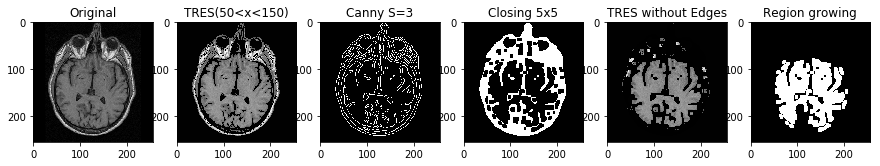

Brain size =  14304


In [8]:
#edge detection, treshold and region growing on binary
tresl=50;
tresu=150;
brain_tres=brain_im.copy();
brain_tres[brain_im<=tresl]=1;
brain_tres[brain_im>=tresu]=0;

edge=feature.canny(brain_tres,sigma=1.5);
edge_c1=morphology.binary_closing(edge,np.ones((6,6)));
brain_tres2=brain_tres.copy();
brain_tres2[edge_c1==True]=0

brain2=regionGrowing(edge_c1,0,0,(100,100));

fig, (ax0 , ax1, ax2,ax3,ax4,ax5) =plt.subplots(1,6,figsize=(15,15));
ax2.imshow(edge,cmap='gray');
ax2.set_title("Canny S=%d"%3.2)
ax3.imshow(edge_c1,cmap='gray');
ax3.set_title("Closing 5x5");

ax5.imshow(brain2,cmap='gray');
ax5.set_title("Region growing")
ax4.imshow(brain_tres2,cmap='gray');
ax4.set_title("TRES without Edges")
ax1.imshow(brain_tres,cmap='gray');
ax1.set_title("TRES(%d<x<%d)"%(tresl,tresu))
ax0.imshow(brain_im,cmap='gray')
ax0.set_title("Original")
plt.show()

size2=np.sum(brain2)
print("Brain size = ",size2)

This doesn't really improve the quality much, but the result that can be obtained with using a treashold is already dignificantly better than withount.

One source of problems in edge detection is noise. This is why we try to apply a median filter to the image before detecting edges.

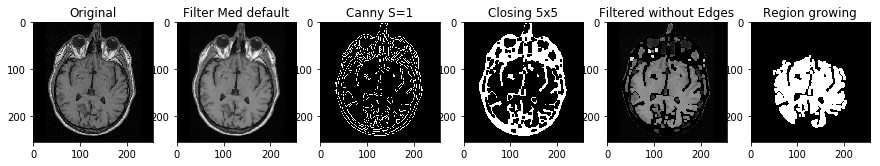

Brain size =  14272


In [9]:
#combined median, canny,closing, region growing on binary
from skimage import filters
brain_fil=skimage.filters.median(brain_im)


edge=feature.canny(brain_fil,sigma=1);
edge_c1=morphology.binary_closing(edge,np.ones((5,5)));
brain_fil2=brain_fil.copy();
brain_fil2[edge_c1==True]=0


brain3=regionGrowing(edge_c1,0,0,(100,100));


fig, (ax0 , ax1, ax2,ax3,ax4,ax5) =plt.subplots(1,6,figsize=(15,15));
ax0.imshow(brain_im,cmap='gray')
ax0.set_title("Original")
ax1.imshow(brain_fil,cmap='gray')
ax1.set_title("Filter Med default")
ax2.imshow(edge,cmap='gray');
ax2.set_title("Canny S=%d"%1)
ax3.imshow(edge_c1,cmap='gray');
ax3.set_title("Closing 5x5");
ax4.imshow(brain_fil2,cmap='gray');
ax4.set_title("Filtered without Edges")
ax5.imshow(brain3,cmap='gray');
ax5.set_title("Region growing")

plt.show()

size3=np.sum(brain3)
print("Brain size = ",size3)

THis result is already quite nice, however it doesn't reach the quality of region growing on th treashold. This is why we use finally a median to remove noise,apply a first treshold selection to remove unnecessary regions then the canny detects the edges and we remove the detected edges from the tresholded image. The image has now well defined boundaries which allow to isolate the brain matter using region growing with treashold.

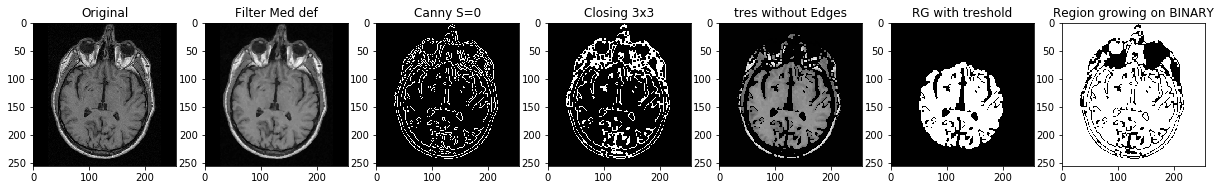

Brain size =  14642


In [10]:
#combined median, treshold, canny, region growing on treshold or binary
tresl=50;
tresu=150;
from skimage import filters

brain_fil=skimage.filters.median(brain_im)

brain_tres=brain_fil.copy();
brain_tres[brain_fil<=tresl]=1;
brain_tres[brain_fil>tresu]=0;

edge=feature.canny(brain_tres,sigma=0.8);
edge_c1=morphology.binary_closing(edge,np.ones((3,3)));
brain_tres2=brain_tres.copy();
brain_tres2[edge_c1==True]=0


brain_bin=regionGrowing(edge_c1,0,0,(100,100));
brain_rg=regionGrowing(brain_tres2,tresl,tresu,(100,100))

fig, (ax) =plt.subplots(1,7,figsize=(3*7,15));
ax[0].imshow(brain_im,cmap='gray')
ax[0].set_title("Original")
ax[1].imshow(brain_fil,cmap='gray')
ax[1].set_title("Filter Med def")
ax[2].imshow(edge,cmap='gray');
ax[2].set_title("Canny S=%d"%0.8)
ax[3].imshow(edge_c1,cmap='gray');
ax[3].set_title("Closing 3x3");
ax[4].imshow(brain_tres2,cmap='gray');
ax[4].set_title("tres without Edges")
#ax[5].axis('off')
ax[5].imshow(brain_rg,cmap='gray');
ax[5].set_title("RG with treshold")
ax[-1].imshow(brain_bin,cmap='gray');
ax[-1].set_title("Region growing on BINARY")

plt.show()

size_rg=np.sum(brain_rg)
print("Brain size = ",size_rg)

### Comparison

Brain Size:
 Region Growing = 12367
 Edge Detection = 14304
 Median,ED = 14272
 Median,ED,TRES = 14642


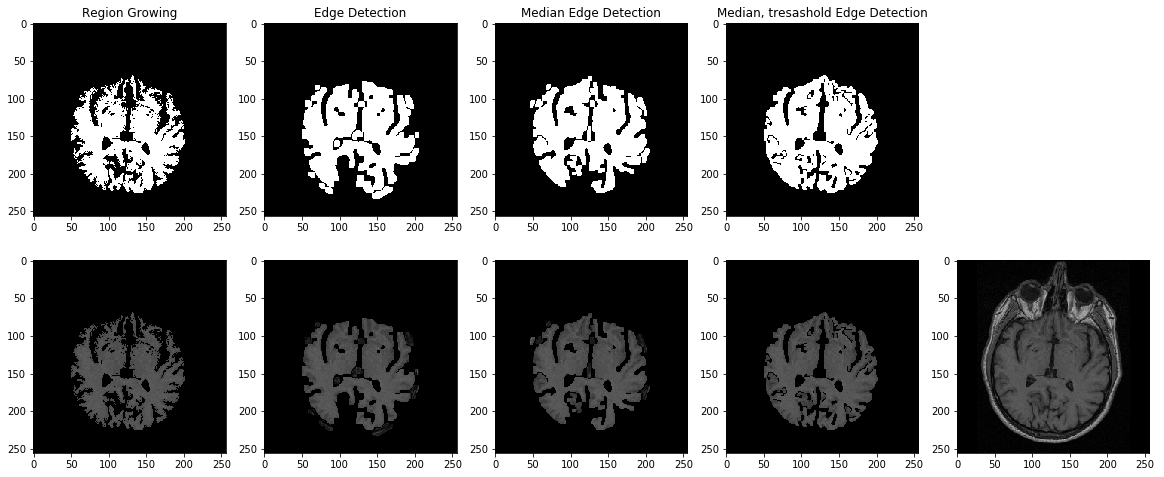

In [11]:
#comparison
fig, (ax) =plt.subplots(2,5,figsize=(5*4,2*4));

ax[0,0].imshow(mask,cmap='gray')
ax[0,0].set_title("Region Growing")
ax[0,1].imshow(brain2,cmap='gray')
ax[0,1].set_title("Edge Detection")
ax[0,2].imshow(brain3,cmap='gray')
ax[0,2].set_title("Median Edge Detection")
ax[0,3].imshow(brain_rg,cmap='gray')
ax[0,3].set_title("Median, tresashold Edge Detection")
ax[0,-1].axis('off')
brain_matter=brain_im.copy();
brain_matter[mask==0]=0;
ax[1,0].imshow(brain_matter,cmap='gray',vmin=0,vmax=255)
brain_matter=brain_im.copy();
brain_matter[brain2==0]=0;
ax[1,1].imshow(brain_matter,cmap='gray',vmin=0,vmax=255)
brain_matter=brain_im.copy();
brain_matter[brain3==0]=0;
ax[1,2].imshow(brain_matter,cmap='gray',vmin=0,vmax=255);
brain_matter=brain_im.copy();
brain_matter[brain_rg==0]=0;
ax[1,3].imshow(brain_matter,cmap='gray',vmin=0,vmax=255);
ax[1,-1].imshow(brain_im,cmap='gray',vmin=0,vmax=255);
print("Brain Size:\n Region Growing = %d\n Edge Detection = %d\n Median,ED = %d\n Median,ED,TRES = %d"%(size_m,size2,size3,size_rg))

The quality of the brain segmentations differ significantly from one method to another. Region growing both on binary or on treashold is essential to extract a continuous domain from the image. And thus eliminate everithing around the region of interest. However if it is applied without other preprocessing there is a risk of loosing brain matter due to the need of a higher initial treashold. By filtering the image and then removing it's edges, the region growing method works extremely well, as the removal of edges quarantées the separation of the object of interest and it's surroundings. At the same time there is not much brain matter lost compared to edge detecion only, as the radius chosen for binary closing of the edges can be kept low as there is no need of a closed edge domain.

As a conclusion: Region growing is in this context best applied on greyscale images, using tresholds. If the region outside of the region of interest is of a similat intensity, edge detection can be used to improve the result significantly. The region growing only detects $84\%$ of the brain matter compared to the combined method. The intermediate results, are not suggested a a good selection, as both details get lost and some of the non-brain matter is wrongfully seperated due to the need of intensive binary closing.

## Part 2: Shape/color segmentation

You will find hereafter a picture of shapes of different colors, taken under four different illuminations.
We ask you to create a routine to:
1. Count the number of shapes of each color.
1. Compute the total area (in pixels) of each color.

One specific challenge is to be robust to illumination changes.
Try to have the same routine(s) running on the four images, and giving (approximatively) the same results.
Therefore some kind of intensity normalization should probably be used.
To help you, you will also find a reference image (palette) with disks of each possible color, that you can use as references.

**Note:** the routine(s) that you will write for this part will be useful for the robot project as well, so pay special attention to it.

### 2.1 Images and palette visualization

In [1]:
#some helpful little functions
def indices(a,func):
    return [i for (i,val) in enumerate(a) if func(val)]
def evaluate(a,ind):
    return [a[i] for i in ind]
def remove(a,val):
    for id,v in enumerate(val):
        a=[x for x in a if x != v]
    return  a

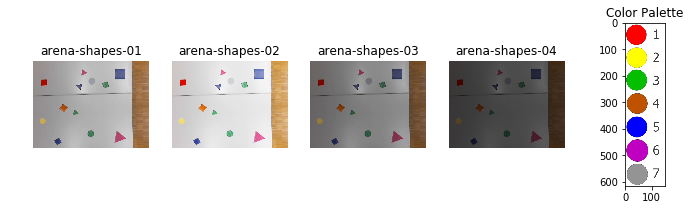

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
    data_path = os.path.join(data_base_path, data_folder)
import skimage.io
from skimage import color
#from skimage import data, color
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03', 'arena-shapes-04']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
images_original=images.copy()
palette = skimage.io.imread(os.path.join(data_path, 'arena-palette.png'))
# Plot images
fig, axes = plt.subplots(1, 5, figsize=(4*3, 1*3))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
axes[-1].imshow(palette)
axes[-1].set_title('Color Palette')
plt.show()


### 2.2 Number of shapes of each color
#### Identify Objects
As all the images have different luminosity, we [rescale the intensity](http://scikit-image.org/docs/dev/api/skimage.exposure.html?highlight=rescale#skimage.exposure.rescale_intensity) to be able to use the same parameters for all images. Then we use [edge detection](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html?highlight=canny) and [binary hole filling](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.morphology.binary_fill_holes.html) to seperate the objects from the background. After that, there may still be some open, unattached edges that can be removed using [binary opening](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.morphology.binary_opening.html#scipy.ndimage.morphology.binary_opening).

The resulting image contains only the objects and background.
#### Label objects
To assign to each object a shape, size, color and other properties we need to label each object.We use [ndi.labels](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html) that analyses pixel connectivity to seperate different objects.

#### SEG_OBJECTS
The function seg_objects does the complete labeling process at once and allows to keep notations short from now on. The input image is scaled within the function so the result should be independent of illumination variations.

If the objects identified are to small to be of concern, a minimal size of the object can be defined that removes the object from the feature map using a median filter. This means as well, that the form of the objects might be compromised if minsize is chosen too large. For this application 10 seems to be appropriate.

/root/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


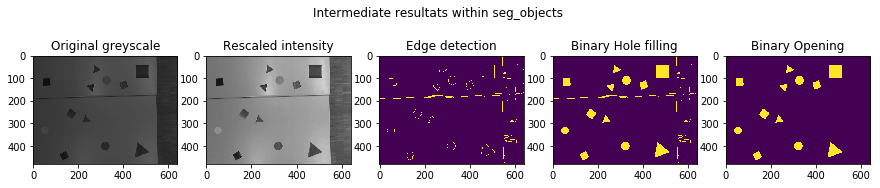

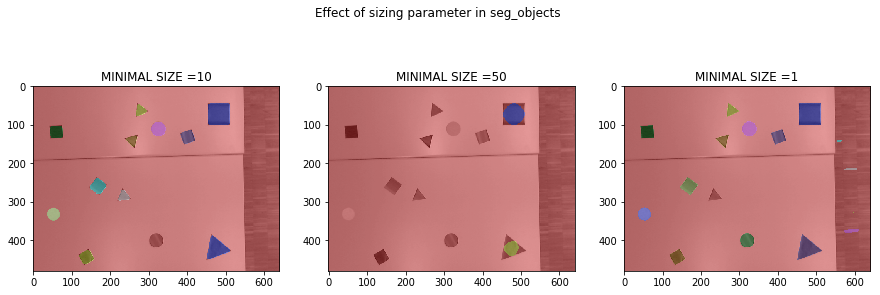

Image has 12 respectively 2 and 16 objects


In [3]:
#label objects
#define function of identification of objects

def seg_objects(im,minsize=1):
    #returns [forms(binary images with all forms), nb_labels(number of objects), label_objects(objects)]
    from skimage.color import rgb2gray
    from skimage.measure import label,regionprops
    from skimage.feature import canny
    from skimage.filters import median
    from skimage.exposure import rescale_intensity
    from scipy.ndimage import binary_fill_holes,binary_opening
    grey=rgb2gray(im);
    greyf=rescale_intensity(grey);
    greyf=median(greyf,np.ones((minsize,minsize)));
    edges=canny(greyf,sigma=0.5);
    forms0 = binary_fill_holes(edges);
    forms1= binary_opening(forms0);
    label_objects, nb_labels = label(forms1,return_num=True);
    region_objects=regionprops(label_objects)
    return forms1, nb_labels,label_objects,region_objects

from skimage import feature,exposure,color
from scipy import ndimage as ndi
grey=color.rgb2gray(images)
greyf=grey[3].copy();
greyf2=exposure.rescale_intensity(greyf);
edges=feature.canny(greyf2,sigma=0.5);
forms0 = ndi.binary_fill_holes(edges);
forms1=ndi.binary_opening(forms0);
#labeling of forms:;
label_objects, nb_labels = ndi.label(forms1);

fig,ax=plt.subplots(1,5,figsize=(5*3,1*3));
fig.suptitle('Intermediate resultats within seg_objects')
ax[0].imshow(grey[3],cmap='gray',vmin=0, vmax=1);
ax[0].set_title("Original greyscale");
ax[1].imshow(greyf2,cmap='gray',vmin=0,vmax=1);
ax[1].set_title("Rescaled intensity");
ax[2].imshow(edges);
ax[2].set_title("Edge detection");
ax[3].imshow(forms0);
ax[3].set_title("Binary Hole filling");
ax[4].imshow(forms1);
ax[4].set_title("Binary Opening");

#demonstration of seg_objects
form,no1,label10,region=seg_objects(images[0],10);
image_label_overlay1 = color.label2rgb(label10, image=images[0]);
form,no2,label50,region=seg_objects(images[0],50);
image_label_overlay2 = color.label2rgb(label50, image=images[0]);
form,no3,label1,region=seg_objects(images[0],1);
image_label_overlay3 = color.label2rgb(label1, image=images[0]);
fig,ax=plt.subplots(1,3,figsize=(3*5,1*5))
fig.suptitle("Effect of sizing parameter in seg_objects")
ax[0].imshow(image_label_overlay1);
ax[0].set_title("MINIMAL SIZE =%d"%10);
ax[1].imshow(image_label_overlay2);
ax[1].set_title("MINIMAL SIZE =%d"%50);
ax[2].imshow(image_label_overlay3);
ax[2].set_title("MINIMAL SIZE =%d"%1);
plt.show();
print("Image has %d respectively %d and %d objects"%(no1,no2,no3))

#### Color detection

The identification of the colors prooves quite difficult for images with luminocities that differ a lot. To estimate the influence of the luminocity, at first the white of the background is adapted to the perfect white of the reference color palette. With this background annulation, the colors have comparable values. However, the colors do not match perfectely the reference colors. There are many possibilities to compare two different RGB tripplets to find the one closest to a reference color such as [Euclidian distances](https://en.wikipedia.org/wiki/Color_difference) that can even be weighted to match better the comparison the human eye does. However it is still very difficult to find a systematic way of comparison the collor, that works on all pictures.

A different method is to convert the images to the HSV-Color space, that defines Hue-color values that define every color shade (starting from red and returning to red) and then uses Saturation and Value to create all possible shades of the colors. The advantage of this system is that it is enough to compare the first value of the triplet to get a good assumption on the color of an object, even in bad luminocity conditions.

<img src="files/hsv.png">

As hue starts at red it also returns to red, thus all reddy shades are difficult to identify. One other problem is that if colors are very close to eachother, like red and violett, or in a grey shade, it is difficult to identify correctly using only HSV. This is why a combination of the tho color spaces is used to compare the colors. HSV to identify the region where a color is in, and then by comparison of RBG ratios, the set colors can be identified.



In [4]:
#identify colors on palette
prop_palette=palette.shape
nocol=7;
colors=palette[prop_palette[0]//nocol//2::prop_palette[0]//nocol,prop_palette[1]//2,:];
colors_hsv=color.rgb2hsv(palette)[prop_palette[0]//nocol//2::prop_palette[0]//nocol,prop_palette[1]//2,:];
name_colors=['red','yellow','green','brown','blue','violett','grey'];

In [14]:
def color_ident(image,col,name_col,col_hsv,bool_print):
    #requres evaluate, remove
    from skimage.exposure import rescale_intensity
    from skimage.color import rgb2hsv,rgb2gray
    from numpy import min,max,mean,nonzero,sum,shape,arange
    from scipy.optimize import minimize_scalar   
    im=image.copy();
    im_col=im.copy();
    nocol=shape(name_col)[0];
    form,no,lab,region=seg_objects(im,10);
    gr=rgb2gray(im);
    gr=rescale_intensity(gr,in_range=(min(gr),max(gr)),out_range=(0,255));
    def f(x):
        return sum(gr<=x)
    for reg in region:
        gr[reg.coords[:,0],reg.coords[:,1]]=0;
    treshold=minimize_scalar(f,bounds=(0,255),method='bounded');
    gr2=gr[:,0:550];
    mask=gr2>treshold.x;
    back_min=min(min(im[:,:],1),0);
    back_max=mean(im[nonzero(mask)][:],0)
    print("---------------------")
    print(back_min,back_max)
    im_col[:,:,0]=rescale_intensity(im[:,:,0],in_range=(back_min[0],back_max[0]),out_range=(back_min[0],255))
    im_col[:,:,1]=rescale_intensity(im[:,:,1],in_range=(back_min[1],back_max[1]),out_range=(back_min[1],255))
    im_col[:,:,2]=rescale_intensity(im[:,:,2],in_range=(back_min[2],back_max[2]),out_range=(back_min[2],255))
    im_hsv=rgb2hsv(im_col);
    col_hsv_sort=col_hsv[col_hsv[:,0].argsort()];
    col_rgb_sort=col[col_hsv[:,0].argsort()]
    name_col_hsv_sort=evaluate(name_col,col_hsv[:,0].argsort());
    name_region_col=[];
    for id,reg in enumerate(region):
        COOR=reg.coords
        region_col=mean(im_hsv[COOR[:,0],COOR[:,1],:],0)
        region_col_rgb=mean(im[COOR[:,0],COOR[:,1],:],0)
        #print(region_col,region_col_rgb)
        dif=[abs(region_col-col_hsv_sort[i,0]) for i,nam in enumerate(name_col_hsv_sort)];
        dif_hue=[d[0] for d in dif];
        possibilities=arange(nocol)
        if region_col[1]<0.1:
            possibilities=[0]
            #grey
        elif region_col[0]<col_hsv_sort[1,0] or region_col[0]>col_hsv_sort[-1,0]:
            possibilities=[nocol-1,nocol-2];
            if region_col_rgb[0]/region_col_rgb[1]>8 and region_col_rgb[0]/region_col_rgb[2]>8:
                possibilities=[nocol-1];
                #red
            elif int(10*region_col[0])==0:
                possibilities=[1];
                #brown
            elif region_col_rgb[2]>30:
                possibilities=[nocol-2];
                #violett
        else:
            possibilities=remove(possibilities,[0,nocol-1]);
            lo=dif_hue==min(evaluate(dif_hue,possibilities))
            possibilities=evaluate(range(nocol),nonzero(dif_hue==min(evaluate(dif_hue,possibilities)))[0])
        name_region_col.append(evaluate(name_col_hsv_sort,possibilities)[0])
        if bool_print:
            print("REGION NO %d is colored %s"%(id,name_region_col[-1]))
    return name_region_col,region


/root/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


[9 0 0] [173.84353314 172.70516204 172.9475267 ]
REGION NO 0 is colored blue
REGION NO 1 is colored violett
REGION NO 2 is colored grey
REGION NO 3 is colored red
REGION NO 4 is colored green
REGION NO 5 is colored blue
REGION NO 6 is colored brown
REGION NO 7 is colored green
REGION NO 8 is colored yellow
REGION NO 9 is colored green
REGION NO 10 is colored violett
REGION NO 11 is colored blue


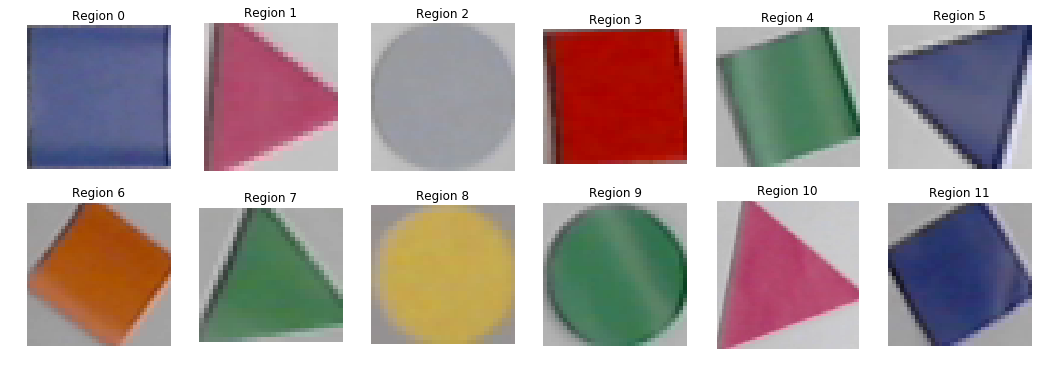

In [12]:
#Show the identified objects
idim=0;
im=images_original[idim];
region_color_name,regions=color_ident(im,colors,name_colors,colors_hsv,True)
fig, axes = plt.subplots(2,6, figsize=(6*3, 2*3))
for ax, enreg in zip(axes.ravel(), enumerate(regions)):
    i=enreg[0];
    reg=enreg[1];
    ax.imshow(images_original[idim][np.min(reg.coords[:,0]):np.max(reg.coords[:,0]),np.min(reg.coords[:,1]):np.max(reg.coords[:,1])])
    ax.axis('off')
    ax.set_title("Region %d"%i)
plt.show()

#### Shape detection
To identify the shape of each object, the [moments_hu](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) property of each region is used. This property of a region is translation,scale and rotational invariant and thus provides a nice differentiation between the different shapes. As for the given shapes the first component much more significant than the others,therefore we only compare this first value. 

In [11]:
#Identify the shape of each object using moments_hu (invariant to Rotations,Translations and stretch)
def shape_detect(region):
    from numpy import round
    shape=[]
    for i,reg in enumerate(region):
        #print(region[i].inertia_tensor)
        if (round(1000*reg.moments_hu)[0]>170):
            #print("Region %d is a %s Triangle"%(i,region_color_name[i]))
            shape.append("T");
        elif (np.round(1000*reg.moments_hu)[0]>161):
            #print("Region %d is a %s Square"%(i,region_color_name[i]))
            shape.append("S");
        else:
            #print("Region %d is a %s Circle"%(i,region_color_name[i]))
            shape.append("C")
    return(shape)  

#Count for every color the number of shapes in the image 
shape=shape_detect(regions)
for nam in name_colors:
    T=0;C=0;S=0;
    for i,reg in enumerate(region_color_name):
        if shape[i]=='T' and reg==nam:
            T=T+1;
        elif shape[i]=='S' and reg==nam:
            S=S+1;
        elif reg==nam:
            C=C+1;
    print("There are %d triangles %d squares and %d circles in %s"%(T,S,C,nam));


There are 0 triangles 1 squares and 0 circles in red
There are 0 triangles 0 squares and 1 circles in yellow
There are 1 triangles 1 squares and 1 circles in green
There are 0 triangles 1 squares and 0 circles in brown
There are 1 triangles 2 squares and 0 circles in blue
There are 2 triangles 0 squares and 0 circles in violett
There are 0 triangles 0 squares and 1 circles in grey


### 2.3 Total area (in pixels) of each color
To count the total area in pixels for each color we can simply add up the number of pixels in each region.

In [10]:
#total area in pixels of each color
for nam in name_colors:
    AREA=0
    for reg_id, reg_col in enumerate(region_color_name):
        if reg_col==nam:
            AREA=AREA+region[reg_id].area;
    print("There are %d Pixels in %s"%(AREA,nam))

There are 1037 Pixels in red
There are 866 Pixels in yellow
There are 2655 Pixels in green
There are 1161 Pixels in brown
There are 4693 Pixels in blue
There are 2689 Pixels in violett
There are 1137 Pixels in grey


### 2.4 Stability of analysis
To proove the stability of the methon, we compare the results obtained for the  four different pictures. It is clearly visible, that the method works similarly for all images.

In [15]:
#show colors for all images
im_regions=[];
im_shapes=[]
for i in range(4):
    region_color_name, region=color_ident(images[i],colors,name_colors,colors_hsv,False);
    shape=shape_detect(region)
    im_regions.append(region_color_name);
    im_shapes.append(shape);
for i in range(4):
    print(im_regions[i])
for i in range(4):
    print(im_shapes[i])

/root/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


---------------------
[9 0 0] [173.84353314 172.70516204 172.9475267 ]
---------------------
[11  0  0] [222.7438696  221.69715095 221.79900617]
---------------------
[6 0 0] [126.93911351 126.05097166 126.30094463]
---------------------
[3 0 0] [69.97519222 69.48246836 69.63636473]
['blue', 'violett', 'grey', 'red', 'green', 'blue', 'brown', 'green', 'yellow', 'green', 'violett', 'blue']
['blue', 'violett', 'grey', 'red', 'green', 'blue', 'brown', 'green', 'yellow', 'green', 'violett', 'blue']
['blue', 'violett', 'grey', 'red', 'green', 'blue', 'brown', 'green', 'yellow', 'green', 'violett', 'blue']
['blue', 'violett', 'grey', 'red', 'green', 'blue', 'brown', 'green', 'yellow', 'green', 'violett', 'blue']
['S', 'T', 'C', 'S', 'S', 'T', 'S', 'T', 'C', 'C', 'T', 'S']
['S', 'T', 'C', 'S', 'S', 'T', 'S', 'T', 'C', 'C', 'T', 'S']
['S', 'T', 'C', 'S', 'S', 'T', 'S', 'T', 'C', 'C', 'T', 'S']
['S', 'T', 'C', 'S', 'S', 'T', 'S', 'T', 'C', 'C', 'T', 'S']
